In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import osmnx as ox
import pandas as pd
import pickle
import tensorflow as tf

In [2]:
tf.__version__

'1.12.0'

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Load the model
Load the training supposed best training checkpoint.

In [4]:
DATASET_NAME = 'geolife'
G_GRU_SIZE = 32
D_GRU_SIZE = 16

g_string = 'g_GRU-{g_gru_size}_rand-32_Dense-3_adam_bce_default_'.format(g_gru_size=G_GRU_SIZE)
d_string = 'd_gin_GRU-{d_gru_size}_Dense-1_adam_bce_default_'.format(d_gru_size=D_GRU_SIZE)
setup_string = g_string + d_string + '{dataset}_64_100'.format(dataset=DATASET_NAME)

In [5]:
setup_string

'g_GRU-32_rand-32_Dense-3_adam_bce_default_d_gin_GRU-16_Dense-1_adam_bce_default_geolife_64_100'

In [6]:
history = pickle.load(open('histories/citybased_gan_2/' + setup_string + '_30.pkl', 'rb'))

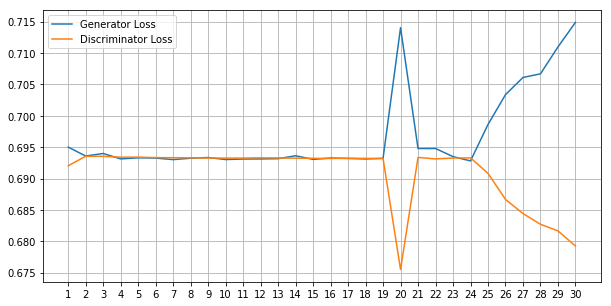

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 31, 1), history['g_loss'], label='Generator Loss')
plt.plot(np.arange(1, 31, 1), history['d_loss'], label='Discriminator Loss')
plt.xticks(np.arange(1, 31, 1))
plt.grid()
plt.legend()
plt.show()

In [8]:
SELECTED_EPOCH = 30

In [9]:
# Load the model
model_path = 'checkpoints/citybased_gan_2/' + setup_string + '_{:02d}_g.h5'.format(SELECTED_EPOCH)
model = tf.keras.models.load_model(model_path)

## Actual generation

In [10]:
N_USERS = 50

Generate user start positions

In [11]:
poskde = pickle.load(open('../data_{dataset}/poskde_{dataset}_000003.pkl'.format(dataset=DATASET_NAME), 'rb'))

In [12]:
startpositions = poskde.sample(N_USERS)

In [13]:
startpositions[:3]

array([[116.37287958,  39.95718402],
       [116.41801117,  39.97606055],
       [117.20224245,  31.63162064]])

Generate start and end times

In [14]:
real_dataset = pd.read_pickle('../data_{dataset}/{dataset}_cut.pkl'.format(dataset=DATASET_NAME))
print('Real begin: {}'.format(real_dataset.index.levels[1].min()))
print('Real end: {}'.format(real_dataset.index.levels[1].max()))
del real_dataset

Real begin: 2008-09-29 00:14:36
Real end: 2008-10-05 23:33:56


In [15]:
BEGIN = pd.Timestamp('2008-09-29 00:00:00')
END = pd.Timestamp('2008-10-05 23:59:59')
total_duration = END - BEGIN
print(total_duration)

6 days 23:59:59


In [16]:
sekde = pickle.load(open('../data_{dataset}/sekde_{dataset}_cut_003.pkl'.format(dataset=DATASET_NAME), 'rb'))

In [17]:
starttimes = np.full(N_USERS, -1.0)
out_of_range = (starttimes < 0) | (starttimes >= 1.0)

while np.any(out_of_range):
    new_samples = np.squeeze(sekde['kde_start'].sample(len(starttimes[out_of_range])))
    starttimes[out_of_range] = new_samples
    out_of_range = (starttimes < 0) | (starttimes >= 1.0)

In [18]:
starttimes[:3]

array([0.10131444, 0.01487546, 0.38628018])

In [19]:
durations = np.zeros(N_USERS)
out_of_range = (durations <= 0) | (starttimes + durations > 1.0)

while np.any(out_of_range):
    new_samples = np.squeeze(sekde['kde_duration'].sample(len(durations[out_of_range])))
    durations[out_of_range] = new_samples
    out_of_range = (durations <= 0) | (starttimes + durations > 1.0)

In [20]:
durations[:3]

array([0.47687826, 0.27013779, 0.55740675])

In [21]:
starttimes = starttimes * total_duration.total_seconds()
starttimes[:3]

array([ 61274.87317534,   8996.66250625, 233621.86806424])

In [22]:
durations = durations * total_duration.total_seconds()
durations[:3]

array([288415.49245323, 163379.06304926, 337119.04676716])

In [23]:
starts = np.concatenate([starttimes.reshape(-1, 1), startpositions], axis=1)

In [24]:
starts[:3]

array([[6.12748732e+04, 1.16372880e+02, 3.99571840e+01],
       [8.99666251e+03, 1.16418011e+02, 3.99760605e+01],
       [2.33621868e+05, 1.17202242e+02, 3.16316206e+01]])

In [25]:
scaler = pickle.load(open('scalers/citybased_gan_2/' + setup_string + '.pkl', 'rb'))

/Users/jankaiser/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.2 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Actual generation loops

In [26]:
ninety_seconds = scaler.transform(np.array([[90.0, 0.0, 0.0]]))[0, 0]
ninety_seconds

-0.00042560859062572206

In [27]:
def generate_user(generator, scaler, start, duration):
    sc = np.array([start])
    s = sc.copy()
    s[0, 0] = 0.0
    s = scaler.transform(s)   
    
    starttime = start[0]
    endtime = starttime + duration
    
    while(sc[-1, 0] <= endtime):        
        x = s[-100:]
        noise = np.random.rand(32)
        
        y = model.predict([x.reshape(1, -1, 3), noise.reshape(1, 32)]).squeeze()
        y[0] = max(ninety_seconds, y[0])
        
        s = np.concatenate([s, y.reshape((1, 3))])
        
        yc = scaler.inverse_transform(y.reshape(1, 3)).squeeze()
        yc[0] = sc[-1, 0] + yc[0]
        
        sc = np.concatenate([sc, yc.reshape((1, 3))])
        
        #print('\r{}'.format(sc[-1, 0] - sc[-2, 0]), end='')
    
    return sc[:-1]

In [28]:
data = []
for u in range(N_USERS):
    print(u)
    s = generate_user(model, scaler, starts[u], durations[u])
    data.append(s)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


Inspect generated data

In [29]:
i = 2

In [30]:
data[i]

array([[ 2.33621868e+05,  1.17202242e+02,  3.16316206e+01],
       [ 2.34463594e+05,  1.04247833e+02,  3.35939217e+01],
       [ 2.35352031e+05,  1.00621536e+02,  3.50168953e+01],
       [ 2.36530938e+05,  9.76616440e+01,  3.65976906e+01],
       [ 2.37920828e+05,  9.29369278e+01,  3.85371056e+01],
       [ 2.39123562e+05,  8.59482956e+01,  4.10117455e+01],
       [ 2.39986453e+05,  7.77897720e+01,  4.34628220e+01],
       [ 2.40108703e+05,  7.25400696e+01,  4.47046013e+01],
       [ 2.40848000e+05,  7.95465698e+01,  4.47828102e+01],
       [ 2.43124516e+05,  9.44201431e+01,  4.38042374e+01],
       [ 2.45391875e+05,  9.46658478e+01,  4.43751335e+01],
       [ 2.46485688e+05,  8.46587143e+01,  4.44976006e+01],
       [ 2.47737891e+05,  8.26205673e+01,  4.40859032e+01],
       [ 2.49113094e+05,  8.54235916e+01,  4.30187111e+01],
       [ 2.51548984e+05,  1.03948738e+02,  4.32035065e+01],
       [ 2.52255047e+05,  8.91657639e+01,  4.36051178e+01],
       [ 2.52345047e+05,  8.01931915e+01

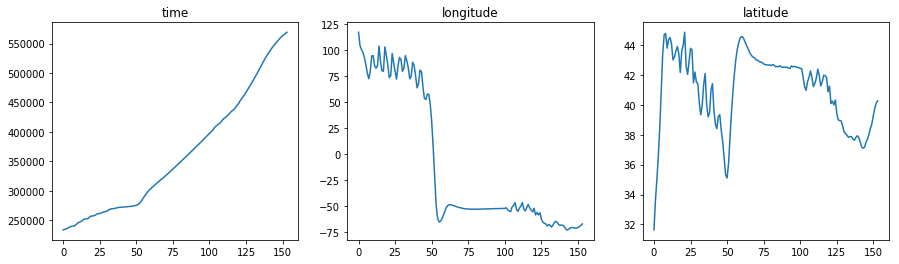

In [31]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.plot(data[i][:, 0])
plt.title('time')
plt.subplot(132)
plt.plot(data[i][:, 1])
plt.title('longitude')
plt.subplot(133)
plt.plot(data[i][:, 2])
plt.title('latitude')
plt.show()

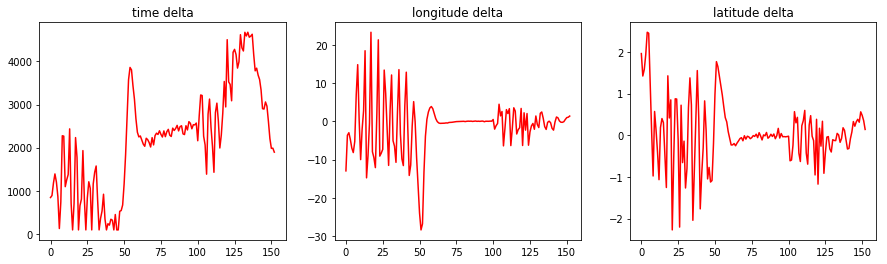

In [32]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.plot(np.diff(data[i][:, 0]), c='red')
plt.title('time delta')
plt.subplot(132)
plt.plot(np.diff(data[i][:, 1]), c='red')
plt.title('longitude delta')
plt.subplot(133)
plt.plot(np.diff(data[i][:, 2]), c='red')
plt.title('latitude delta')
plt.show()

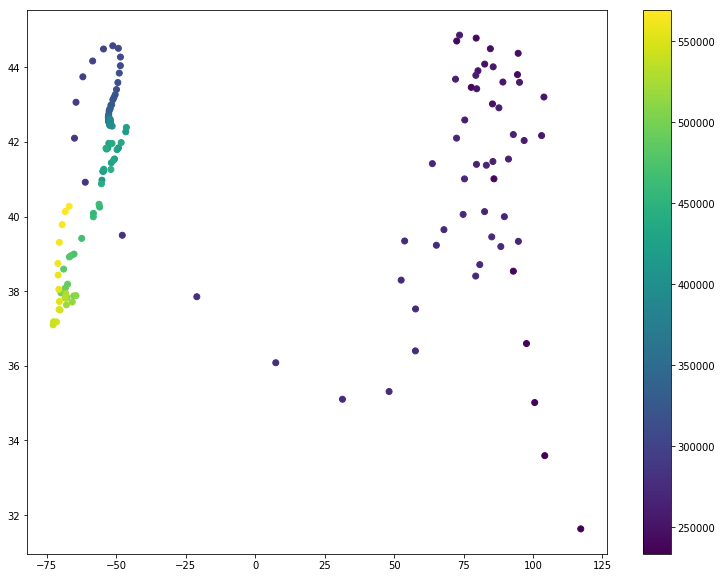

In [33]:
plt.figure(figsize=(13, 10))
plt.scatter(data[i][:, 1], data[i][:, 2], c=data[i][:, 0])
plt.colorbar()
plt.show()

## Convert data to standard format

In [34]:
dfs = []
for u in range(len(data)):
    userdf = pd.DataFrame(data[u], columns=['time', 'longitude', 'latitude'])
    userdf['user'] = u
    userdf['time'] = BEGIN + pd.to_timedelta(userdf['time'], unit='s')
    dfs.append(userdf)

df = pd.concat(dfs, ignore_index=True)
df = df.set_index(['user', 'time'])

df.head()

longitude   latitude
user time                                                
0    2008-09-29 17:01:14.873175343  116.372880  39.957184
     2008-09-29 17:15:46.589843750  112.699394  41.676441
     2008-09-29 17:39:22.296875000  109.398132  44.199055
     2008-09-29 18:00:23.515625000  100.777153  46.651741
     2008-09-29 18:12:42.031250000   97.351891  47.408810

In [35]:
df.to_pickle('generated/citybased_gan_2/' + setup_string + '_cut.pkl')